# Intro

This notebook implements the Helmholtz machine introduced in:

Hinton GE, Dayan P, Frey BJ & Neal RM (1995). The “wake-sleep” algorithm for unsupervised neural networks. Science 268, 1158–1161. ([PDF](http://www.gatsby.ucl.ac.uk/~dayan/papers/hdfn95.pdf))


# Setting up
To organize the code, we'll first create a class representing one layer of our Helmholtz machine.

In this class, each layer is described by its neighbors (the layer above and the layer below) and the weights originating from the layer (i.e. there will be two nUnitsInLayer-by-something weight matrices per layer, one for the recognition weights and one for the generative weights).

The nomenclature follows Figure 1 in Hinton 1995: The input layer is at the lowest positon. Recognition weights point upwards, and generative weights point downwards.

In [3]:
import numpy as np
%qtconsole

class Layer(object):
    def __init__(self, n_units, layer_below=None):
        self.n_units = n_units
        self.state = np.zeros(n_units)
        self.b_rec = np.zeros(self.n_units) # Recognition bias
        self.b_gen = np.zeros(self.n_units) # Generative bias
        self.above = None # Layer above; will be filled when connecting layer from above.
        
        if layer_below is not None:            
            # Create link from self to layer below and initialize
            # the down-going (generative) weights:
            self.below = layer_below
            self.init_w_gen()
                        
            # Create link from layer below to self and initialize
            # the up-going (recognition) weights:
            layer_below.above = self
            layer_below.init_w_rec()
        else:
            self.below = None
            
    def init_w_rec(self):
        """Initialize reconstruction weights originating from this layer."""
        self.w_rec = np.zeros((self.n_units, self.above.n_units))
        
    def init_w_gen(self):
        """Initialize generative weights originating from this layer."""
        self.w_gen = np.zeros((self.n_units, self.below.n_units))
        
    def get_C(self):
        """Get the description length of all units in the layer."""
        # Equations 2 and 3 in Hinton 1995.
        
        if self.above is None:
            p = sigmoid(-self.b_gen)
        else:
            p = sigmoid(-self.b_gen - self.above.state.dot(self.above.w_gen).T)
        return np.sum(-(self.state * np.log(p)) - (1-self.state) * np.log(1-p))

# Wake phase

In the wake phase, the recognition weights are fixed and the generative weights are trained.

Equation 4 in Hinton 1995 provides the update rule:

$$ \Delta w_{kj} = \epsilon s_k^\alpha (s_j^\alpha - p_j^\alpha) $$

This is the derivative of the objective given in equation (3). The update specifies that for each active presynaptic neuron, the weight of the connection to each postsynaptic neuron should change in proportion to the difference between the current state of the postsynaptic neuron and the probability that the neuron should be active, as specified by the weights of the network.

In [4]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(x))

def drive_layer_wake(layer_below, layer_above):
    """Determine neuronal activations according to the recognition weights."""
    # In the wake phase, we use the recognition weights to choose activations,
    # from the input layer at the bottom upwards.
    
    # Equation 1 in Hinton 1995:
    p = sigmoid(-layer_above.b_rec - layer_below.state.dot(layer_below.w_rec).T)
    
    # Sample binary states according from distribution p:
    layer_above.state = p > np.random.random_sample(p.shape)

def train_layer_wake(layer_below, layer_above):
    """Change generative weights based on recognition activations."""
    # Based on equation 4 in Hinton 1995.
    
    if layer_above is None:
        # No layer_above means we're training the top layer:
        # Just adjust the biases to match the current state.
        p = sigmoid(-layer_below.b_gen)
        layer_below.b_gen = layer_below.b_gen + (epsilon *
                            (layer_below.state - p))
    else:
        p = sigmoid(-layer_below.b_gen - layer_above.state.dot(layer_above.w_gen).T)
        layer_above.w_gen = layer_above.w_gen + (epsilon * 
                            np.outer(layer_above.state, (layer_below.state - p)))
        # Update bias. This is not described in the paper, but
        # http://www.gatsby.ucl.ac.uk/~dayan/papers/d2000a.pdf
        # suggests that it should be done like this:
        layer_below.b_gen = layer_below.b_gen + (epsilon *
                            (layer_below.state - p))

# Sleep phase
In the sleep phase, we drive the network using the generative weights to dream up "fantasies" of what the input to the network might look like according to the generative model. We then change the recognition weights to match the generative model as closely as possible: Given one of the fantasies as input, the recognition weights should be such that, when the network is driven by this input, it goes to a state that resembles the state used to dream up that fantasy.

In [5]:
def drive_layer_sleep(layer_below, layer_above):
    """Determine neuronal activations according to the generative weights."""
    
    # Equation 1 in Hinton 1995:
    p = sigmoid(-layer_below.b_gen - layer_above.state.dot(layer_above.w_gen).T)
    
    # Sample binary states according from distribution p:
    layer_below.state = p > np.random.random_sample(p.shape)

def train_layer_sleep(layer_below, layer_above):
    """Change recognition weights based on generative activations."""
    # Based on equation 7 in Hinton 1995.
    
    if layer_below is None:
        # No layer_below means we're training the bottom layer:
        # Just adjust the biases to match the current input.
        q = sigmoid(-layer_above.b_rec)        
        layer_above.b_rec = layer_above.b_rec + (epsilon *
                            (layer_above.state - q))
    else:
        q = sigmoid(-layer_above.b_rec - layer_below.state.dot(layer_below.w_rec).T)
        layer_below.w_rec = layer_below.w_rec + (epsilon * 
                            np.outer(layer_below.state, (layer_above.state - q)))
        layer_above.b_rec = layer_above.b_rec + (epsilon *
                           (layer_above.state - q))

# Putting the layers together
To orchestrate the training, we create a Network class. The Network object will contain a number of layers an coordinate the driving and training sweeps through the network:

In [6]:
class Network(object):
    def __init__(self, nInput):
        self.layers = [Layer(nInput)]
        self.nLayers = 1
        
    def addLayer(self, nUnits):
        self.layers.append(Layer(nUnits, self.layers[-1]))
        self.nLayers += 1
        
    def drive_wake(self, input_state):
        self.layers[0].state = input_state
        for i in range(self.nLayers-1):
            drive_layer_wake(self.layers[i], self.layers[i+1])
        
    def train_wake(self):
        train_layer_wake(self.layers[-1], None)
        for i in range(self.nLayers-2, -1, -1):
            train_layer_wake(self.layers[i], self.layers[i+1])

    def drive_sleep(self):
        p = sigmoid(-self.layers[-1].b_gen)
        self.layers[-1].state = np.random.random_sample(self.layers[-1].state.shape) < p
        for i in range(self.nLayers-2, -1, -1):
            drive_layer_sleep(self.layers[i], self.layers[i+1])

    def train_sleep(self):
        train_layer_sleep(None, self.layers[0])
        for i in range(self.nLayers-1):
            train_layer_sleep(self.layers[i], self.layers[i+1])
            
    def get_C(self):
        """Get description length of whole network."""
        return np.sum([layer.get_C() for layer in self.layers])

# Data preprocessing
Hinton 1995 uses a handwritten digit dataset "from the CEDAR CDROM 1" (endnote 7). This dataset is still available, if you're willing to part with $950 and wait for a CDROM to be mailed to you. I am not, so I'm using the freely available MNIST dataset instead. Hinton's images measure 8 by 8 pixels. Downsampling the 28 by 28 MNIST images to 8 by 8 makes them almost unrecognizable. 14 by 14 is a reasonable compromise between image quality and training duration.

In [7]:
import load_mnist as load_mnist
from scipy.misc import imresize
import sys

# Load data (only training since we're not actually testing anything):
im_train_raw, label_train = load_mnist.load_mnist(dataset="training", digits=np.arange(10), path="C:\\Users\\Matthias\\GitHub\\personal\\neuralNets\\mnist")

# Only use the easier first half of the data:
im_train_raw = im_train_raw[0:30000, :, :]
label_train = label_train[0:30000]

# Downsample dataset:
h = 14
w = 14
im_train = np.zeros((im_train_raw.shape[0], h, w))
for i in range(im_train.shape[0]):
    img = im_train_raw[i,:,:,]
    
    # Crop and center digit so there is no whitespace around it:
    B = np.argwhere(img)
    (ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1
    cropped = img[ystart:ystop, xstart:xstop]
    square = np.zeros((np.max((xstop-xstart, ystop-ystart))) + (0, 0))
    x_ind = np.arange(cropped.shape[1])+(square.shape[1]-cropped.shape[1])/2
    y_ind = np.arange(cropped.shape[0])+(square.shape[0]-cropped.shape[0])/2
    square[y_ind.min():y_ind.max()+1, x_ind.min():x_ind.max()+1] = cropped
    im_train[i,:,:,] = imresize(square, (h, w))
    if i%1000 == 0:
        sys.stdout.write('.')

print('Done.')

# Binarize dataset:
im_train = im_train > 10 # 10 looks best

..............................Done.


Let's plot a few examples to make sure the preprocessing worked:

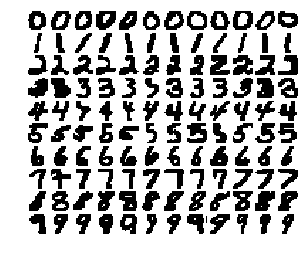

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    ind_digit_here = (label_train==i).nonzero()
    ind = np.random.randint(ind_digit_here[0].size)
    img_row = im_train[ind_digit_here[0][ind],:,:]
    for j in range(1, 12):
        ind = np.random.randint(ind_digit_here[0].size)
        img = im_train[ind_digit_here[0][ind],:,:]
        img_row = np.concatenate((img_row, np.zeros((img.shape[0], 2)), img), 1)
    if i is 0:
        img_grid = img_row
    else:
        img_grid = np.concatenate((img_grid, np.zeros((2, img_row.shape[1])), img_row), 0)

plt.imshow(-img_grid, interpolation="nearest", cmap="gray");
plt.gca().axis('off');

Like the paper, we can use the "naive" description length (see endnote 7) of the data as a benchmark for our network:

In [9]:
mean_desc_length_digit = np.zeros(10)
for i in range(10):
    i_digit_here = (label_train==i).nonzero()[0]
    p = np.maximum(np.mean((im_train[i_digit_here, :, :]), 0).ravel(), 1e-10)
    for i_example in range(i_digit_here.size):
        state = im_train[i_digit_here[i_example], :, :].ravel()
        mean_desc_length_digit[i] += np.sum(-(state * np.log(p)) - (1-state) * np.log(1-p))
    mean_desc_length_digit[i] /= i_digit_here.size
mean_desc_length = np.mean(mean_desc_length_digit)
print('The mean description length for the current dataset is {:1.1f}.').format(mean_desc_length)

The mean description length for the current dataset is 91.0.


## Network architecture

I decided to skip the individual networks for the 10 digits and just build one large network which encodes all 10 digits. The description length provides a measure for the performance of the network.

Hinton's input images measured 8 by 8 pixels and he used a 64-32-32-16 architecture for the single network that processes all digits jointly.

Playing around with the network architecture didn't reveal any simple relationships between performance and architecture. Larger networks just took longer to train. So I'll just use Hinton's 32-32-16 hidden layer sizes. The input layer will have 196 units to match the image size (14*14).

The weights are automatically initialized to zero by the Layer class defined above.

In [10]:
# Input layer:
nPix = h * w
network = Network(nPix)

# Add hidden layers:
network.addLayer(32)
network.addLayer(32)
network.addLayer(16)

Now we can start training the network.

In [ ]:
# Plot description length to monitor training progress:
%matplotlib auto
plt.ion()
fig = plt.figure()
ax = plt.axes()
h_line, = plt.plot([], [], 'r-')
plt.xlabel('Iteration')
plt.title('Description length')
xdata=[0]
ydata=[0]

# Learning rate:
epsilon = 0.01 # Hinton 1995 uses 0.01 (see endnote 7).

nEpoch = 1
nTrain = label_train.size
iIter = 0;
for iEpoch in range(nEpoch):
    print(iEpoch+1)
    random_order = np.random.permutation(nTrain)
    for iExample in random_order:
        iIter += 1
        
        # Wake phase (bottom-up pass):
        # Drive the network using the example:
        network.drive_wake(im_train[iExample, :, :].ravel())
        
        # Learn the generative weights based on input:
        network.train_wake()
        
        # Sleep phase (top-down pass):
        # Drive the network using a dreamed-up (random) fantasy:
        network.drive_sleep()
        
        # Learn the recognition weights based on fantasy:
        network.train_sleep()
        
        # Show training progress by plotting current description length:
        if iIter%100 is 0:
            xdata.append(iIter)     # Append new data to list
            ydata.append(network.get_C())
            h_line.set_data(xdata, ydata) # update data
            ax.relim()        # Recalculate limits
            ax.autoscale_view(True,True,True) #Autoscale
            fig.canvas.draw()
            fig.canvas.flush_events()
            

In [957]:
# Save layers as list of dicts:
netDictList = []
for i in range(len(network)):
    netDictList.append(network[i].__dict__)
    
f = open('sleepWake_state_14by14_netIsHintonSized_after10Miter_netDictList.pckl', 'w')
pickle.dump(netDictList, f)
f.close()

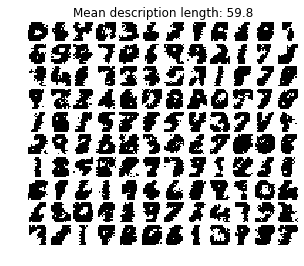

In [39]:
# Show some fantasies:
%matplotlib inline
description_length = 0
for i in range(10):
    network.drive_sleep()
    description_length += network.get_C()
    img_row = np.reshape(network.layers[0].state, im_train[0].shape)
    for j in range(1, 12):
        network.drive_sleep()
        description_length += network.get_C()
        img = np.reshape(network.layers[0].state, im_train[0].shape)
        img_row = np.concatenate((img_row, np.zeros((img.shape[0], 2)), img), 1)
    if i is 0:
        img_grid = img_row
    else:
        img_grid = np.concatenate((img_grid, np.zeros((2, img_row.shape[1])), img_row), 0)

description_length /= (i+1)*(j+1)
plt.imshow(-img_grid, interpolation="nearest", cmap="gray");
plt.gca().axis('off');
plt.title(('Mean description length: {:1.1f}').format(description_length));

After 3 million iterations (rougly the same number of iterations as in the paper), the mean description length is about 2/3 of the "naive" description length of the data. The fantasies look reasonably similar to the data, but are a bit noisy.

10 more million iterations (several hours of training) improve the mean description length by a few percent and remove some of the noise, but don't make a qualitative difference.

## Convenience functions:

In [ ]:
# Back-up network as list of dicts:
import pickle
netDictList = []
for i in range(len(network)):
    netDictList.append(network.layers[i].__dict__)
    
f = open('sleepWake_state_14by14_after10Miter_netDictList.pckl', 'w')
pickle.dump(netDictList, f)
f.close()

In [33]:
# Load pickled state:
import pickle
f = open('sleepWake_state_14by14_after3Miter_netDictList.pckl', 'r')
#f = open('sleepWake_state_14by14_after10Miter_netDictList.pckl', 'r')
netDictList = pickle.load(f)
f.close()
for i in range(len(netDictList)):
    if i is 0:
        network = Network(netDictList[i]['n_units'])
    else:
        network.addLayer(netDictList[i]['n_units'])
        
    for key in netDictList[i]:
        setattr(network.layers[i], key, netDictList[i][key])

In [73]:
# Set process priority low:
import win32api,win32process,win32con
pid = win32api.GetCurrentProcessId()
handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
win32process.SetPriorityClass(handle, win32process.BELOW_NORMAL_PRIORITY_CLASS)